In [173]:
# import nidaqmx
# import os
# import time
# import numpy as np
# import matplotlib.pyplot as plt

# import pyfirmata
# # import time
# board = pyfirmata.Arduino('COM3')

# # board.exit()


# # task_write0 = nidaqmx.Task()
# # task_write0.ao_channels.add_ao_voltage_chan("Dev5/ao1", min_val=0, max_val=5)

# # def daq_sqwave(n):
# #     for _ in range(n):
# #         task_write0.write(5) ## Give Voltage Value for pk-pk (5 V for Marker and 0.5 V for Sync)
# #         # task_write0.stop()
# #         time.sleep(0.01) ### Pulse width
# #         task_write0.write(0)
# #         task_write0.stop()
# #         # task_dig.stop()
# #         time.sleep(0.1) ### Time between two operations of for loop
# #         # task_dig.stop()
# #     return 'Done'

# # task_dig = nidaqmx.Task()
# # task_dig.do_channels.add_do_chan('Dev5/port0/line0')

# # # task_dig.write(True,auto_start=True)
# # # time.sleep(0.01)
# # # task_dig.write(False,auto_start=True)

# # def daq_sqwave(n):
# #     for _ in range(n):
# #         task_dig.write(True,auto_start=True) ## 500 mV pk-pk
# #         time.sleep(0.05) ### Pulse width
# #         # task_write2.stop()
# #         # time.sleep(0.0001)


# #         task_dig.write(False,auto_start=True)
# #         # task_dig.stop()
        
# #         # task_write0.stop()
# #         task_dig.stop()
# #         time.sleep(0.1)
# #     return 'Done'
# # daq_sqwave(10)
# # daq_sqwave(10)

In [174]:
# def ard_sqwave(n):
#     for _ in range(n):
#         board.digital[13].write(1)
#         time.sleep(0.005)
#         board.digital[13].write(0)
#         time.sleep(0.1)
#     return 'Done'
# # ard_sqwave(20)

# # def ard_sqwave(n):
# #     for _ in range(n):
# #         board.digital[13].write(1)
# #         time.sleep(0.005)
# #         board.digital[13].write(0)
# #         time.sleep(2)
# #     return 'Done'
# # ard_sqwave(5)





In [184]:
from AMC_python import AMC
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from TimeTagger import *
# import numpy as np
# import matplotlib.pyplot as plt
from IPython.display import clear_output
# import time
from __future__ import print_function
import sys
tt = createTimeTagger()


def histo(t):
    tt.getOverflowsAndClear()
    PIXEL_START_CH = 2 # Rising edge on input 1
    SPD_CH = 3
    n_values = 6600
    binwidth = 5
    chist = Histogram(tt, SPD_CH, PIXEL_START_CH, binwidth,n_values)
    chist.startFor(t) #60e12 #in ps
    while chist.isRunning():
        arr = chist.getData()
        clear_output(wait=True)
        plt.plot(range(len(arr)),arr[range(len(arr))])
        plt.show()
    return arr
    # clear_output(wait=True)
    
    # print(chist.getData())
    # time.sleep(20)
    # chist.stop()
# plt.plot(range(len(arr)),arr[range(len(arr))])

def fit_lifetime(x):
    m = range(len(x))
    max_i = np.argmax(x)
    t1 = m[max_i:]
    x1 = x[max_i:]
    def expdec(t,a,l,b):
    # a = x[max_i]
        return a*np.exp(-(t-np.argmax(x))/l) + b
    params, cov = curve_fit(expdec, t1, x1)
    return params[1]

    # i = i + 1

# def expdec(t,a,l,b):
#     # a = x[max_i]
#     return a*np.exp(-(t-max_i)/l) + b

# def fit_lifetime(x):
#     m = range(len(x))
#     max_i = np.argmax(x)
#     t1 = m[max_i:]
#     x1 = x[max_i:]
#     params, cov = curve_fit(expdec, t1, x1)
#     return params[1]
# # import time

IP = "192.168.1.1"

# Setup connection to AMC
amc = AMC.Device(IP)
amc.connect()

# Activate axis 1
# Internally, axes are numbered 0 to 2
axis0 = 0 # Axis 1
amc.control.setControlOutput(axis0, True)

# Activate axis 2
axis1 = 1 # Axis 2
amc.control.setControlOutput(axis1, True)

axis2 = 2 # Axis 2
amc.control.setControlOutput(axis2, True)



from IPython.display import clear_output
# y_move = 10
# x_move = 19
### RASTER SCAN FUNCTION: Run this before next kernel
# cbm = CountBetweenMarkers(tt, SPD_CH, PIXEL_START_CH, PIXEL_STOP_CH, n_pixels)

def raster_scan(x_move,y_move,x_step,y_step):
    # count_data = cbm.getData()
    t = 30e12
    # x_step = 1
    # y_step = 50
    pos_xy = []
    times = np.zeros((y_move,x_move+1))
    
    # clear_output(wait=True)
    # pos_xy = [(0,0)]*(y_move*(x_move+1))
    # plt.plot(*zip(*pos_xy),'g.')
    # plt.show()
    # j = 0
    # pos_xy = [(amc.move.getPosition(axis0),amc.move.getPosition(axis1))]
    amc.control.setControlAmplitude(axis1,35000) #22500 #35000 #25000 
    m = 0
    for i in range(y_move):
        x = i
        amc.move.setNSteps(axis1, False, y_step) ## Moves Up == False
        # amc.move.setNSteps(axis1, True, y_step)  ## Moves Down == True
        # cbm.getData()
        # ard_sqwave(1) ## DAQ trigger
        time.sleep(0.5) ## stop time in seconds
        print((amc.move.getPosition(axis0),amc.move.getPosition(axis1)))
        
        histy = histo(t)
        pos_xy.append((amc.move.getPosition(axis0),amc.move.getPosition(axis1),0.005*fit_lifetime(histy)))
        # clear_output(wait=True)
        if x%2 == 1:
            times[i,x_move] = 0.005*fit_lifetime(histy)
        else:
            times[i,0] = 0.005*fit_lifetime(histy)
        # plt.imshow(times)
        # plt.show()
#         clear_output(wait=True)
        
#         plt.plot(*zip(*pos_xy),'g.')
#         plt.show()
        
        # pos_xy[m] = (amc.move.getPosition(axis0),amc.move.getPosition(axis1))
        print(i)
        # print((amc.move.getPosition(axis0),amc.move.getPosition(axis1)))
        # print(count_data)
        # m = m+1
        for j in range(x_move):
            # amc.move.setNSteps(axis0, x%2, x_step)
            if x%2 == 1:
                ### BACKWARD
                amc.control.setControlAmplitude(axis0,34300) ## Changes amplitude in back (x avis) #22600 #25000 34300
                # amc.control.setControlFrequency(axis0,999000)
            else:
                ### FORWARD
                amc.control.setControlAmplitude(axis0,42301)  ## Changes amplitude in fwd (x avis) #27301 #29501  42301
                # amc.control.setControlFrequency(axis0,999000)
                
            amc.move.setNSteps(axis0, x%2, x_step)  ## Moves in x
            # pos_xy[m] = (amc.move.getPosition(axis0),amc.move.getPosition(axis1))
            # ard_sqwave(1) ## DAQ trigger
            time.sleep(0.5) ## stop time in seconds
            print((amc.move.getPosition(axis0),amc.move.getPosition(axis1)))
            histx = histo(t)
            pos_xy.append((amc.move.getPosition(axis0),amc.move.getPosition(axis1),0.005*fit_lifetime(histx)))
            # clear_output(wait=True)
            # plt.plot(*zip(*pos_xy),'g.')
            # plt.show()
            # clear_output(wait=True)
            if x%2 == 0:
                times[i,j+1] = 0.005*fit_lifetime(histx)
            else:
                times[i,x_move-(j+1)] = 0.005*fit_lifetime(histx)
                
            # plt.imshow(times)
            # plt.show()
            print(j)
            
            # print(j,i,amc.control.getControlAmplitude(axis0),(amc.move.getPosition(axis0),amc.move.getPosition(axis1)))
            # pos_xy.append((amc.move.getPosition(axis0),amc.move.getPosition(axis1),cbm.getData()[m]))
            # print(j,i,amc.control.getControlAmplitude(axis0),(amc.move.getPosition(axis0),amc.move.getPosition(axis1)),cbm.getData()[m])
            # # print(count_data)
            # m = m+1
           
            # pos_x.append(amc.move.getPosition(axis0))
        # print('Pos_x: ',amc.move.getPosition(axis0))
        # pos_xy.append((amc.move.getPosition(axis0),amc.move.getPosition(axis1)))
        # amc.move.setNSteps(axis1, False, y_step)
        # pos_xy.append((amc.move.getPosition(axis0),amc.move.getPosition(axis1)))
        # print(j,i,(amc.move.getPosition(axis0),amc.move.getPosition(axis1)))
        # # daq_sqwave(1)
        # time.sleep(0.5)
    # return print('Scan Over')
    # cbm.stop()
    img = plt.imshow(times)
    cbar = plt.colorbar(img)
    plt.show()
    print(pos_xy[0])
    return pos_xy

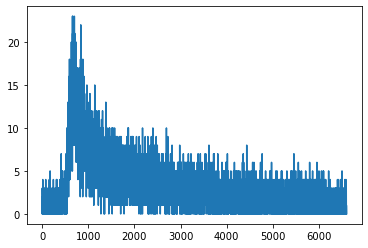

(1713917.102, 789642.032)
3


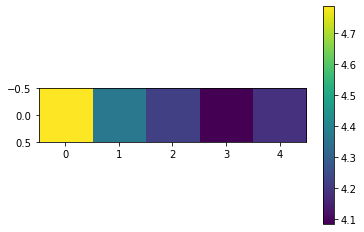

(1710891.284, 789636.897, 4.7853620111917605)


In [185]:
x_step = 1 #
y_step = 1
y_move = int(input("No. of steps in y:"))
x_move = int(input("No. of steps in x:"))
scan_num = int(input("Scan num:"))
save = input("Do you want to save the xy data for this scan (Yes or No)?")
from datetime import datetime
date = datetime.today().strftime('%Y%m%d') #'20221207'
folder_name = datetime.today().strftime('%B-%Y') #'20221207'
sample = input("Sample name (without space):")
# print(save.type)

# while cbm.isRunning():
#     clear_output(wait=True)
    
#     # time.sleep(10)
#     img = cr.getData()
#     plt.plot(range(img.shape[1]),img[0][range(img.shape[1])])
#     plt.show()
# clear_output(wait=True)
# plt.plot(*zip(*p),'g.')
# plt.show()
p = raster_scan(x_move,y_move,x_step,y_step)
# print(p[0])
if save == 'Yes':
    import pandas as pd
    df = pd.DataFrame(p, columns = ['X_data','Y_data','Lifetime'])

    # # path = 'C:\\Users\\Praveen\\Desktop\\NVspectrum\\September-2022\\28_10_2022'
    path = 'D:\\Data\\'+folder_name+'\\'+date
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

    df.to_csv(path+'\\'+sample+'_scan'+str(scan_num)+'_FLIM.csv', index=False)
    xy = [(i[0],i[1]) for i in p]
    print('Your file is saved as:',path+'\\'+sample+'_scan'+str(scan_num)+'_FLIM.csv')    

# l1 = [0]*(y_move*y_move)
# l2 = l1
# len(list(zip(l1,l2)))

In [177]:
# plt.imshow(times)
# t = 30e12
# histo(t)

print(p)

[(1709004.935, 788115.543, 6.381268650009814), (1709819.202, 788099.241, 4.976419857847626), (1710596.503, 788101.143, 4.949157621961008), (1711360.244, 788096.475, 4.362787089425145), (1712111.186, 788097.19, 5.250111684608296), (1712866.553, 788089.957, 4.4422287773401194)]


In [183]:
# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
while True:
    tt.getOverflowsAndClear()
    

KeyboardInterrupt: 

In [151]:
# # for i in range(len(p)):
# from scipy.optimize import curve_fit
# #     x = 
# # i_max = np.amax(x:=p[0][2])
# m = np.where(p[0][2][np.argmax(x):] == int(0.37*i_max))
# # print(m,p[0][2][np.argmax(x):])
# m = p[0][2]
# inten = m[np.argmax(m):]
# timeps = np.arange(5*np.argmax(m),5*6600,5)
# # len(timeps)
# # len(inten)
# # timeps
# # np.argmax(x)
# # (625-633)*5
# # inten
# # guess_b, guess_d = 5000
# # guess = [guess_b,guess_d]
# # def test(x, b,y0):
# #     return np.amax(m)*np.exp(-(x)/(b))
# # def cal_lifetime():
# #     i_max = np.amax

# # params = curve_fit(test, timeps, inten, p0=guess)
# # params

# import pandas as pd
# df2 = pd.DataFrame(p,columns=['x','y','intensity'])

# df2.to_csv('flim_test.csv', index = False)
# # plt.plot(timeps,inten)
# p1 = [i[2] for i in p]



# def fit_lifetime(x):
#     m = range(len(x))
#     max_i = np.argmax(x)
#     t1 = m[max_i:]
#     x1 = x[max_i:]
#     def expdec(t,a,l,b):
#     # a = x[max_i]
#         return a*np.exp(-(t-np.argmax(x))/l) + b
#     params, cov = curve_fit(expdec, t1, x1)
#     return params[1]

# # fit_lifetime(p1[0])
# tau = [5*fit_lifetime(i)/1000 for i in p1]
# tau

[3.978930785389284, 3.6234431007188412, 5.156311492890031, 3.2366750967457403]

In [44]:
folder_name = datetime.today().strftime('%B-%Y') #'20221207'
# file_name
path = 'D:\\Data\\'+folder_name+'\\'+date


Your file is saved as: D:\Data\December-2022\20221208\Dye_scan1_MH_XY.csv


In [171]:
# # # print(p[1][0]-p[2][0],p[13][0]-p[14][0],p[1][1]-p[13][1])
# # with open("fl.txt",mode="w",errors="replace") as fp:
# #     for item in p:
# #         # write each item on a new line
# #         fp.write(item,"\n")
# #     fp.close()
# import csv

# with open("out.csv", "w") as f:
#     # wr = csv.writer(f)
#     wr = csv.writer(f, delimiter=",")
#     wr.writerows(p)
#     # wr.writerows(list_of_lists)
    
# with open("out.csv", "w") as f:
p1 = [i[2].T for i in p]
df = pd.DataFrame(p1).T
# len(p1)
# df[3]
df.to_csv('fl_test.csv', index = False)

p

[(1709353.236, 788070.268, 4.743557241601019),
 (1710165.862, 788062.848, 5.1641080351696065),
 (1710938.453, 788066.973, 5.26877602823466),
 (1711697.501, 788070.578, 4.136394519970274),
 (1712445.067, 788069.233, 3.835154116190555),
 (1713212.966, 788069.925, 3.641538364184764)]

In [168]:
# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
while True:
    tt.getOverflowsAndClear()
    

KeyboardInterrupt: 

In [169]:
board.exit()
freeTimeTagger(tt)
# tt.getOverflows()

True

In [136]:
###########################  END  ########################################

In [134]:
## Return to XY ref positions
ref_posx = -2920591 #-589350 #nm
amc.move.setControlTargetPosition(axis0, ref_posx)
amc.control.setControlMove(axis0, True)


In [39]:
# ref_posy = 368485 #nm
# amc.move.setControlTargetPosition(axis1, ref_posy)
# amc.control.setControlMove(axis1, False)
for i in range(y_move):    
    amc.move.setNSteps(axis1, True, y_step)

In [40]:
# p[0][1]-p[1][1]

# p
# df = pd.DataFrame(p, columns = ['X_data','Y_data'])
# scan_num = 5

#     # # path = 'C:\\Users\\Praveen\\Desktop\\NVspectrum\\September-2022\\28_10_2022'
# path = 'D:\\Data\\November-2022\\'+date
# df.to_csv(path+'\\'+sample+'_scan'+str(scan_num)+'_MH_XY.csv', index=False)

-196.77700000000186 237.35899999993853 205.44099999999162


In [26]:
x_move = 9
y_move = 10
l1 = [(0,0)]*(y_move*(x_move+1))
# len(l1)
l1[0] = (1,2)

# print(l1)


In [186]:
freeTimeTagger(tt)

True